## <div style="color:#fff;display:fill;border-radius:10px;background-color:#3c968b;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%">🛠️ Libraries and Setup</div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
from PIL import Image
import random
import h5py
from tqdm.notebook import tqdm, trange
import io
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split


## <div style="color:#fff;display:fill;border-radius:10px;background-color:#3c968b;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%">📊 EDA (Exploratory Data Analysis)</div>

In [2]:
DATA_PATH = Path("data")

In [3]:
train_metadata_df = pd.read_csv(DATA_PATH / "train-metadata.csv")
train_metadata_df

,img_id,target
0,image_0.jpg,1.0
1,image_1.jpg,1.0
2,image_10016.jpg,1.0
3,image_10017.jpg,1.0
4,image_10018.jpg,1.0
...,...,...
19995,ISIC_9997208.jpg,0.0
19996,ISIC_9997401.jpg,0.0
19997,ISIC_9999071.jpg,0.0
19998,ISIC_9999762.jpg,0.0


In [4]:
list(train_metadata_df.columns)

['img_id', 'target']

In [5]:
train_metadata_df["target"].value_counts()

target
1.0    10000
0.0    10000
Name: count, dtype: int64

In [6]:
train_imgs_filenames = os.listdir(DATA_PATH / "train-image/image/images/")
print(train_imgs_filenames[:5]) 
print("len imgs:", len(train_imgs_filenames))

['image_0.jpg', 'image_1.jpg', 'image_10016.jpg', 'image_10017.jpg', 'image_10018.jpg']
len imgs: 20000


['image_5153.jpg', 'image_24290.jpg', 'image_59872.jpg', 'image_74944.jpg', 'image_49858.jpg', 'image_7072.jpg', 'image_59392.jpg', 'image_27875.jpg']


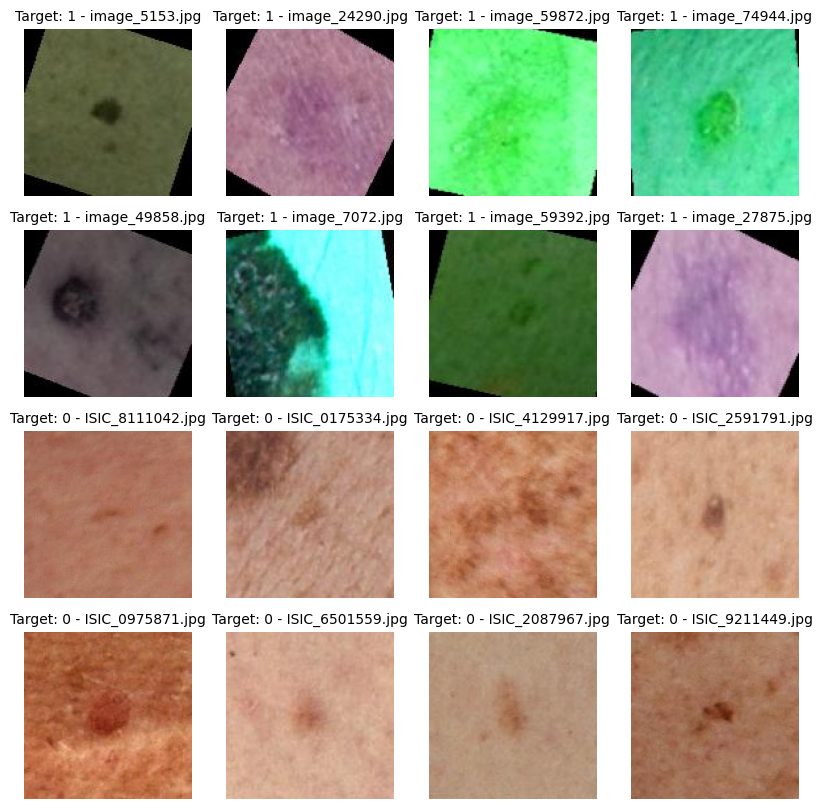

In [7]:
pos_img_files = random.sample(list(train_metadata_df.loc[train_metadata_df["target"] == 1]["img_id"]), 8)
neg_img_files = random.sample(list(train_metadata_df.loc[train_metadata_df["target"] == 0]["img_id"]), 8)
print(pos_img_files)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

for ax, image_file, target in zip(axs.flatten(), pos_img_files+neg_img_files, [1]*8+[0]*8):
    img = Image.open(f"data/train-image/image/images/{image_file}")
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"Target: {target} - {image_file}", fontsize=10)
    
# plt.tight_layout()
plt.show()

Balancing dataset

In [8]:
train_metadata_df.target.value_counts()

target
1.0    10000
0.0    10000
Name: count, dtype: int64

In [9]:
no_cancer = train_metadata_df[train_metadata_df['target']==0][:10000]
no_cancer

,img_id,target
10000,ISIC_0073777.jpg,0.0
10001,ISIC_0075770.jpg,0.0
10002,ISIC_0076244.jpg,0.0
10003,ISIC_0076936.jpg,0.0
10004,ISIC_0077306.jpg,0.0
...,...,...
19995,ISIC_9997208.jpg,0.0
19996,ISIC_9997401.jpg,0.0
19997,ISIC_9999071.jpg,0.0
19998,ISIC_9999762.jpg,0.0


In [10]:
cancer = train_metadata_df[train_metadata_df['target']==1][:10000]
cancer

,img_id,target
0,image_0.jpg,1.0
1,image_1.jpg,1.0
2,image_10016.jpg,1.0
3,image_10017.jpg,1.0
4,image_10018.jpg,1.0
...,...,...
9995,image_9955.jpg,1.0
9996,image_9984.jpg,1.0
9997,image_9985.jpg,1.0
9998,image_9986.jpg,1.0


In [11]:
# %%time
# def read_images_from_hdf5(file_path):
#     with h5py.File(file_path, 'r') as file:
#         ids_list = list(file.keys())        
#         ids_images = {}
#         for img_id in tqdm(ids_list):
#             image_data = file[img_id][()]
#             image = Image.open(io.BytesIO(image_data))
#             ids_images[img_id] = np.array(image)
            
#     return ids_images

# train_imgs = read_images_from_hdf5(DATA_PATH / "train-image.hdf5")
# train_imgs[list(train_imgs.keys())[0]], train_imgs[list(train_imgs.keys())[0]].shape

In [12]:
# Check if that images are squared and plot sizes distribution

# sizes = []
# for k in train_imgs:
#     if train_imgs[k].shape[0] != train_imgs[k].shape[1]:
#         print(k, train_imgs[k].shape[0], train_imgs[k].shape[1])
#     sizes.append(train_imgs[k].shape[0])
    
# plt.hist(sizes, bins=50)
# plt.show()

## <div style="color:#fff;display:fill;border-radius:10px;background-color:#3c968b;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%">🗂️ Dataset and Dataloader</div>

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

In [14]:
class SkinCancerDataset(Dataset):
    def __init__(
        self, 
        metadata_df, 
        root_dir=DATA_PATH/"train-image/image/images/", 
        transform=None,
        train=True,
    ):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.metadata: pd.DataFrame = metadata_df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_name = self.root_dir / f"{self.metadata.iloc[idx]['img_id']}"
        image = Image.open(img_name).convert("RGB")
        label = int(self.metadata.iloc[idx]["target"])

        if self.transform:
            image = self.transform(image)

        return image, label

In [15]:
transform = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)


In [16]:
# Split the dataset into training and testing sets
train_metadata, val_metadata = train_test_split(train_metadata_df, test_size=0.1, stratify=train_metadata_df['target'])

# Create datasets
train_dataset = SkinCancerDataset(metadata_df=train_metadata, transform=transform)
val_dataset = SkinCancerDataset(metadata_df=val_metadata, transform=transform)

In [17]:
# Calculate class weights to balance them

class_counts = train_metadata['target'].value_counts().to_dict()
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
sample_weights = [class_weights[target] for target in train_metadata['target']]

class_weights

{0.0: 0.00011111111111111112, 1.0: 0.00011111111111111112}

In [18]:
# The sampler will balance the positive and negative classes in the loader
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2048, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=2048, shuffle=False)

torch.Size([2048, 3, 128, 128])


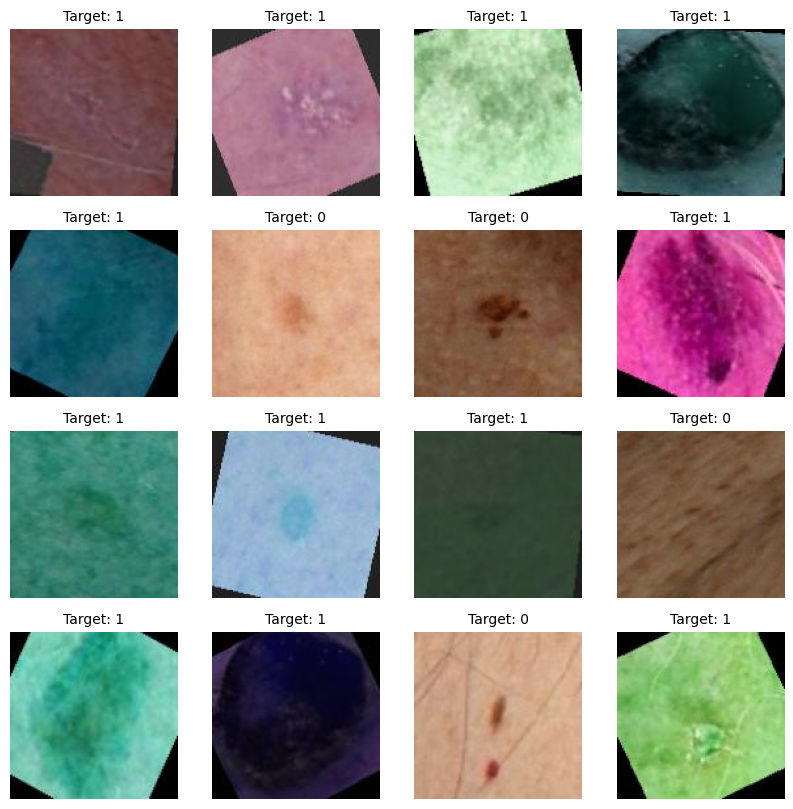

In [19]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape)
for ax, img, label in zip(axs.flatten(), images, labels):
    img = img.permute(1, 2, 0).numpy() / 2 + 0.5
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"Target: {label}", fontsize=10)
    
# plt.tight_layout()
plt.show()

In [20]:
from sklearn.metrics import roc_curve, auc


def score(solution: np.array, submission: np.array, min_tpr: float=0.80) -> float:

    # rescale the target. set 0s to 1s and 1s to 0s (since sklearn only has max_fpr)
    v_gt = abs(solution-1)
    
    # flip the submissions to their compliments
    v_pred = -1.0 * submission

    max_fpr = abs(1-min_tpr)

    # using sklearn.metric functions: (1) roc_curve and (2) auc
    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
        
    # Add a single point at max_fpr by linear interpolation
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)
    
    return partial_auc

## <div style="color:#fff;display:fill;border-radius:10px;background-color:#3c968b;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%">🤖 CNN Pytorch Model definition</div>

In [21]:
# Define a CNN model

class SkinCancerNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, 5)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 3)
        self.bn4 = nn.BatchNorm2d(128)

        # Calculate the size of the feature map after the conv and pool layers
        # Input size: 128x128
        # After conv1: (128 - 5 + 1) = 124 -> 124x124
        # After pool1: 124 / 2 = 62 -> 62x62
        # After conv2: (62 - 5 + 1) = 58 -> 58x58
        # After pool2: 58 / 2 = 29 -> 29x29
        # After conv3: (29 - 3 + 1) = 27 -> 27x27
        # After pool3: 27 / 2 = 13.5 -> 13x13 (rounding down)
        # After conv4: (13 - 3 + 1) = 11 -> 11x11
        # After pool4: 11 / 2 = 5.5 -> 5x5 (rounding down)

        self.fc1 = nn.Linear(128 * 5 * 5, 512)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))

        return x
    
    
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

model = SkinCancerNet()
model = model.to(device)

Device: cuda:0


In [22]:

# Loss Function and Optimizer

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## <div style="color:#fff;display:fill;border-radius:10px;background-color:#3c968b;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%">📈 Training Loop</div>

In [23]:
debug = False

# Early stopping
last_loss = 100
patience = 2
triggertimes = 0
# Train the model

for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(tqdm(train_loader)):
        # get the inputs; data is a list of [inputs, labels]
        
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs).flatten()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        n = 5
        if i % n == n-1:    # print every 2000 mini-batches
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss/n:.4f}")
            running_loss = 0.0
        
        if debug:
            if i > n: break
    

            
    correct = 0
    total = 0
    all_probs = []
    all_labels = []
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, data in enumerate(tqdm(val_loader)):
            images, labels = data[0].to(device), data[1].float().to(device)
            # calculate outputs by running images through the network
            probs = model(images).flatten()
            all_probs.extend(probs.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
            # the class with the highest energy is what we choose as prediction
            predicted = (probs >= 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if debug:
                if i > 3: break

    print(len(all_labels), len(all_probs))
    print(all_labels[:5], all_probs[:5])
                  
    print(f"Accuracy of the model: {100 * correct // total} %")
    print(f"AUC of the model: {score(np.array(all_labels), np.array(all_probs), min_tpr=0.0)}")
    print(f"pAUC-TPR(0.8) of the model: {score(np.array(all_labels), np.array(all_probs))}")

    if running_loss < last_loss:
        triggertimes = 0
    else:
        triggertimes += 1
    if triggertimes > patience:
        print("Early stopping")
        break
    last_loss = running_loss

print('Finished Training')

  0%|          | 0/9 [00:00<?, ?it/s]

[1,     5] loss: 0.6998


  0%|          | 0/1 [00:00<?, ?it/s]

2000 2000
[1.0, 1.0, 1.0, 1.0, 0.0] [0.5038591623306274, 0.47881078720092773, 0.5062903761863708, 0.5315403938293457, 0.5100980997085571]
Accuracy of the model: 43 %
AUC of the model: 0.4079205
pAUC-TPR(0.8) of the model: 0.0040459999999999975


  0%|          | 0/9 [00:00<?, ?it/s]

[2,     5] loss: 0.6949


  0%|          | 0/1 [00:00<?, ?it/s]

2000 2000
[1.0, 1.0, 1.0, 1.0, 0.0] [0.5051727890968323, 0.5024201273918152, 0.5334147810935974, 0.5178771615028381, 0.507934033870697]
Accuracy of the model: 51 %
AUC of the model: 0.537216
pAUC-TPR(0.8) of the model: 0.009222999999999995


  0%|          | 0/9 [00:00<?, ?it/s]

[3,     5] loss: 0.6894


  0%|          | 0/1 [00:00<?, ?it/s]

2000 2000
[1.0, 1.0, 1.0, 1.0, 0.0] [0.49856194853782654, 0.4903855621814728, 0.5141955614089966, 0.5314795970916748, 0.5054119229316711]
Accuracy of the model: 58 %
AUC of the model: 0.7062865
pAUC-TPR(0.8) of the model: 0.03598349999999998


  0%|          | 0/9 [00:00<?, ?it/s]

[4,     5] loss: 0.6826


  0%|          | 0/1 [00:00<?, ?it/s]

2000 2000
[1.0, 1.0, 1.0, 1.0, 0.0] [0.5207816958427429, 0.48975810408592224, 0.496243417263031, 0.5582984685897827, 0.5047801733016968]
Accuracy of the model: 64 %
AUC of the model: 0.814944
pAUC-TPR(0.8) of the model: 0.07278699999999998


  0%|          | 0/9 [00:00<?, ?it/s]

[5,     5] loss: 0.6751


  0%|          | 0/1 [00:00<?, ?it/s]

2000 2000
[1.0, 1.0, 1.0, 1.0, 0.0] [0.5411231517791748, 0.5093094706535339, 0.5199650526046753, 0.6148434281349182, 0.49793267250061035]
Accuracy of the model: 67 %
AUC of the model: 0.8788009999999999
pAUC-TPR(0.8) of the model: 0.11148749999999996


  0%|          | 0/9 [00:00<?, ?it/s]

[6,     5] loss: 0.6667


  0%|          | 0/1 [00:00<?, ?it/s]

2000 2000
[1.0, 1.0, 1.0, 1.0, 0.0] [0.5387352705001831, 0.5113329887390137, 0.5347619652748108, 0.6030318737030029, 0.5014594197273254]
Accuracy of the model: 71 %
AUC of the model: 0.917302
pAUC-TPR(0.8) of the model: 0.13860899999999993


  0%|          | 0/9 [00:00<?, ?it/s]

[7,     5] loss: 0.6562


  0%|          | 0/1 [00:00<?, ?it/s]

2000 2000
[1.0, 1.0, 1.0, 1.0, 0.0] [0.6105810403823853, 0.5243478417396545, 0.53578120470047, 0.590133786201477, 0.5110520124435425]
Accuracy of the model: 75 %
AUC of the model: 0.9500059999999999
pAUC-TPR(0.8) of the model: 0.15917899999999996


  0%|          | 0/9 [00:00<?, ?it/s]

[8,     5] loss: 0.6425


  0%|          | 0/1 [00:00<?, ?it/s]

2000 2000
[1.0, 1.0, 1.0, 1.0, 0.0] [0.5773245096206665, 0.5141879916191101, 0.5865118503570557, 0.6287679076194763, 0.49822095036506653]
Accuracy of the model: 79 %
AUC of the model: 0.963077
pAUC-TPR(0.8) of the model: 0.16959199999999996


  0%|          | 0/9 [00:00<?, ?it/s]

[9,     5] loss: 0.6225


  0%|          | 0/1 [00:00<?, ?it/s]

2000 2000
[1.0, 1.0, 1.0, 1.0, 0.0] [0.6669613122940063, 0.5827083587646484, 0.5449362397193909, 0.731656551361084, 0.4807034730911255]
Accuracy of the model: 81 %
AUC of the model: 0.9688789999999999
pAUC-TPR(0.8) of the model: 0.17430299999999999


  0%|          | 0/9 [00:00<?, ?it/s]

[10,     5] loss: 0.6002


  0%|          | 0/1 [00:00<?, ?it/s]

2000 2000
[1.0, 1.0, 1.0, 1.0, 0.0] [0.6639288663864136, 0.5847833156585693, 0.5731265544891357, 0.7512572407722473, 0.4800238013267517]
Accuracy of the model: 85 %
AUC of the model: 0.976862
pAUC-TPR(0.8) of the model: 0.18030699999999994


  0%|          | 0/9 [00:00<?, ?it/s]

[11,     5] loss: 0.5699


  0%|          | 0/1 [00:00<?, ?it/s]

2000 2000
[1.0, 1.0, 1.0, 1.0, 0.0] [0.7760672569274902, 0.6327447295188904, 0.6471147537231445, 0.8117498159408569, 0.4683380424976349]
Accuracy of the model: 88 %
AUC of the model: 0.9773839999999999
pAUC-TPR(0.8) of the model: 0.18072099999999994


  0%|          | 0/9 [00:00<?, ?it/s]

[12,     5] loss: 0.5367


  0%|          | 0/1 [00:00<?, ?it/s]

2000 2000
[1.0, 1.0, 1.0, 1.0, 0.0] [0.8176040649414062, 0.7256190180778503, 0.6773849129676819, 0.8783003687858582, 0.47891172766685486]
Accuracy of the model: 91 %
AUC of the model: 0.983785
pAUC-TPR(0.8) of the model: 0.18547499999999995


  0%|          | 0/9 [00:00<?, ?it/s]

[13,     5] loss: 0.5019


  0%|          | 0/1 [00:00<?, ?it/s]

2000 2000
[1.0, 1.0, 1.0, 1.0, 0.0] [0.8941832780838013, 0.6458097100257874, 0.7237781882286072, 0.8438461422920227, 0.48120561242103577]
Accuracy of the model: 92 %
AUC of the model: 0.984407
pAUC-TPR(0.8) of the model: 0.18584899999999993


  0%|          | 0/9 [00:00<?, ?it/s]

[14,     5] loss: 0.4679


  0%|          | 0/1 [00:00<?, ?it/s]

2000 2000
[1.0, 1.0, 1.0, 1.0, 0.0] [0.9238998889923096, 0.7797225117683411, 0.7603950500488281, 0.956490695476532, 0.4522070586681366]
Accuracy of the model: 93 %
AUC of the model: 0.9857939999999998
pAUC-TPR(0.8) of the model: 0.18736099999999994


  0%|          | 0/9 [00:00<?, ?it/s]

[15,     5] loss: 0.4321


  0%|          | 0/1 [00:00<?, ?it/s]

2000 2000
[1.0, 1.0, 1.0, 1.0, 0.0] [0.9581266641616821, 0.8552395701408386, 0.8138342499732971, 0.9314526915550232, 0.4203832447528839]
Accuracy of the model: 95 %
AUC of the model: 0.986546
pAUC-TPR(0.8) of the model: 0.18752399999999997


  0%|          | 0/9 [00:00<?, ?it/s]

[16,     5] loss: 0.4059


  0%|          | 0/1 [00:00<?, ?it/s]

2000 2000
[1.0, 1.0, 1.0, 1.0, 0.0] [0.9688247442245483, 0.7914292812347412, 0.779388964176178, 0.9960876703262329, 0.44607260823249817]
Accuracy of the model: 95 %
AUC of the model: 0.9890709999999999
pAUC-TPR(0.8) of the model: 0.19014399999999995


  0%|          | 0/9 [00:00<?, ?it/s]

[17,     5] loss: 0.3770


  0%|          | 0/1 [00:00<?, ?it/s]

2000 2000
[1.0, 1.0, 1.0, 1.0, 0.0] [0.9990729093551636, 0.8401268124580383, 0.7794447541236877, 0.9961709380149841, 0.4374946355819702]
Accuracy of the model: 96 %
AUC of the model: 0.98945
pAUC-TPR(0.8) of the model: 0.19030499999999995


  0%|          | 0/9 [00:00<?, ?it/s]

[18,     5] loss: 0.3398


  0%|          | 0/1 [00:00<?, ?it/s]

2000 2000
[1.0, 1.0, 1.0, 1.0, 0.0] [0.9703841209411621, 0.9100970029830933, 0.9673375487327576, 0.994329035282135, 0.3824322819709778]
Accuracy of the model: 96 %
AUC of the model: 0.987756
pAUC-TPR(0.8) of the model: 0.18826399999999996


  0%|          | 0/9 [00:00<?, ?it/s]

[19,     5] loss: 0.3135


  0%|          | 0/1 [00:00<?, ?it/s]

2000 2000
[1.0, 1.0, 1.0, 1.0, 0.0] [0.9900997281074524, 0.940650999546051, 0.9802647829055786, 0.9486922025680542, 0.352433443069458]
Accuracy of the model: 96 %
AUC of the model: 0.9879089999999999
pAUC-TPR(0.8) of the model: 0.18799199999999994


  0%|          | 0/9 [00:00<?, ?it/s]

[20,     5] loss: 0.2734


  0%|          | 0/1 [00:00<?, ?it/s]

2000 2000
[1.0, 1.0, 1.0, 1.0, 0.0] [0.9950903654098511, 0.9682508707046509, 0.9615495204925537, 0.9585599303245544, 0.322109192609787]
Accuracy of the model: 97 %
AUC of the model: 0.9877400000000001
pAUC-TPR(0.8) of the model: 0.18773999999999996
Finished Training


In [25]:
torch.save(model.state_dict(), "model.pth")



In [45]:
# def predict(model, img):
#     img = Image.open(img)
#     img = img.resize((128, 128))
#     img = np.array(img)
#     img = np.transpose(img, (2, 0, 1))
#     img = torch.tensor(img, dtype=torch.float)
#     img = img.unsqueeze(0)
#     img = img.to(device)
#     with torch.no_grad():
#         op = model(img)
#     return op
    
def predict(image):
    image = Image.open(image)
    image = image.resize((128, 128))
    image = transforms.ToTensor()(image)
    image = image.reshape(1, 3, 128, 128)

    with torch.no_grad():
        output = model(image)
    return output

In [48]:
with torch.no_grad():
    prediction = predict('OIP.jpg')

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [44]:
predict

<function __main__.predict(model, img)>